In [127]:
# Growth Area Coordinates
# In this file we use the output from Growth data suburbs.ipynb to 
    # - map the suburbs in Geoapify
    # - merge with the PTV data from the PTV_suburb out put
    # - map Dan Andrews train project to see if it works with top growth areas
import pandas as pd
import matplotlib.pyplot as plt
import requests
import json
import hvplot.pandas
from config import geoapify_key

In [128]:
growth_data = pd.read_csv("Output/grmelbourne_growth_byarea.csv")
ptv_data = pd.read_csv("Output/PTV_suburb.csv")
suburb_list = pd.DataFrame (growth_data[["Area Name"]])

# Use a sample when testing the API to save time - un-comment line below
# suburb_list=suburb_list.sample(5)


In [129]:
# !!!!!!!!!!!!!!!
# In stead of running this script you can import the CSV for the rest




base_url = "https://api.geoapify.com/v1/geocode/search"
params = {
    "apiKey":geoapify_key,
    "format":"json"
            }

for index, row in suburb_list.iterrows():
    area = row["Area Name"] + ",Vic,Australia"
    params["text"] = f"{area}"
    response = requests.get(base_url, params=params).json()
    
    try:
        suburb_list.loc[index, "Lat"] = response["results"][0]["lat"]
        suburb_list.loc[index, "Lon"] = response["results"][0]["lon"]
        suburb_list.loc[index, "place_id"] = response["results"][0]["place_id"]
        suburb_list.loc[index, "addr_1"] = response["results"][0]["address_line1"]
        suburb_list.loc[index, "addr-2"] = response["results"][0]["address_line1"]
        suburb_list.loc[index, "Confidence"] = response["results"][0]["rank"]["confidence"]
        suburb_list.loc[index, "Municipality"] = response["results"][0]["municipality"]
        suburb_list.loc[index, "Suburb_geoapify"] = response["results"][0]["suburb"]
        suburb_list.loc[index, "bbox_lat1"] = response["results"][0]["bbox"]["lat1"]
        suburb_list.loc[index, "bbox_lat2"] = response["results"][0]["bbox"]["lat2"]
        suburb_list.loc[index, "bbox_lon1"] = response["results"][0]["bbox"]["lon1"]
        suburb_list.loc[index, "bbox_lon2"] = response["results"][0]["bbox"]["lon2"]
        # print (f"Area Name {area} found")

    except KeyError as e:
       
        print(f"{e.args[0]} results not found for {suburb_list.loc[index, 'Area Name']}")
    
# print(json.dumps(response, indent=4, sort_keys=True))



suburb results not found for Bunyip
suburb results not found for Garfield
suburb results not found for Cockatoo
municipality results not found for Flemington Bridge
suburb results not found for Flinders
suburb results not found for Gisborne
suburb results not found for Hastings
municipality results not found for Hillside
suburb results not found for Koo Wee Rup
suburb results not found for Macedon
suburb results not found for Melton
suburb results not found for Tooradin
municipality results not found for Point Nepean
suburb results not found for Riddells Creek
suburb results not found for Romsey
suburb results not found for Sunbury
suburb results not found for Wallan
suburb results not found for Wandin
suburb results not found for Whittlesea


In [130]:
suburb_list.to_csv("Output/suburb_list_coordinates.csv")

In [131]:
# drop outliers and areas that cant be reconciled due to unconventional Vic growth data area names
remove =["Hillside", "Point Nepean"]
suburb_list = suburb_list[~suburb_list["Area Name"].isin(remove)]

growth_mapped_geopafy =pd.merge(growth_data, suburb_list, how ="right", on="Area Name")



In [132]:
# save csv file 
growth_mapped_geopafy.to_csv("Output/growth_mapped_geopafy.csv")

In [144]:
#add station data for Dan Andrews rail project to the dataframe
station_list=["Werribee","Sunshine","Melbourne Airport","Broadmeadows","Fawkner","Reservoir","Bundoora","Heidelberg","Doncaster","Box Hill","Burwood","Glen Waverley","Clayton","Cheltenham"]

base_url = "https://api.geoapify.com/v1/geocode/search"
params = {
    "apiKey":geoapify_key,
    "format":"json"
            }

index_reg = len(suburb_list)

for station in station_list:
    
    area = station + ", Vic, Australia"
    params["text"] = f"{area}"
    response = requests.get(base_url, params=params).json()
 
    try:
        growth_mapped_geopafy.loc[index_reg, "Area Name"] = station
        growth_mapped_geopafy.loc[index_reg, "Lat"] = response["results"][0]["lat"]
        growth_mapped_geopafy.loc[index_reg, "Lon"] = response["results"][0]["lon"]
        growth_mapped_geopafy.loc[index_reg, "Confidence"] = response["results"][0]["rank"]["confidence"]
        growth_mapped_geopafy.loc[index_reg, "Total Growth %"] = 1
        growth_mapped_geopafy.loc[index_reg, "Total Growth"] = 20000
        growth_mapped_geopafy.loc[index_reg, "Municipality"] = "Station"
        # print ("i did it")
    except KeyError as e:
        print(f"{e.args[0]} results not found for {suburb_list.loc[index, 'Area Name']}")
    index_reg += 1


In [145]:
map_plot1 = growth_mapped_geopafy.hvplot.points(
    "Lon",
    "Lat",
    geo = True,
    tiles = "OSM",
    frame_width = 800,
    frame_height = 400,
    size = "Total Growth",
    scale = 0.07,
    color = "Municipality"
)

map_plot1

:Overlay
   .Tiles.I  :Tiles   [x,y]
   .Points.I :Points   [Lon,Lat]   (Municipality,Total Growth)

In [148]:
total_growth_fromscsv = growth_data["Total Growth"].sum()
# exclude station growth used for mapping purposes
total_growth_mapped = growth_mapped_geopafy["Total Growth"].sum()-14*20000
percentage_growth_mapped = (total_growth_mapped/total_growth_fromscsv)*100
percentage_growth_mapped = f"{percentage_growth_mapped:.2f}%"
total_growth_fromscsv=f"{total_growth_fromscsv:,.0f}"

print (f"We were able to map {percentage_growth_mapped} of the total growth of {total_growth_fromscsv} reported by Victoria")

We were able to map 97.46% of the total growth of 2,153,491 reported by Victoria


In [149]:

suburb_growth_bins=growth_mapped_geopafy.copy()
growth_bins=[0,0.3,0.4,0.5,0.6,0.7,0.8,0.9, 10]
labels=["<30%","$40%","50%", "60%", "70%", "80%","90%",">100%"]
suburb_growth_bins["Growth % per suburb"]=pd.cut(suburb_growth_bins['Total Growth %'], growth_bins, labels=labels)

suburb_growth_bins_count = suburb_growth_bins.groupby(["Growth % per suburb"]).count()["Total Growth %"]
suburb_growth_bins_total = suburb_growth_bins.groupby(["Growth % per suburb"]).sum()["Total Growth"]
suburb_growth_bins_average = suburb_growth_bins.groupby(["Growth % per suburb"]) ["Total Growth"].mean()
suburb_growth_bins_perc = suburb_growth_bins.groupby(["Growth % per suburb"]) ["Total Growth %"].mean()

suburb_growth_bins = pd.DataFrame({"Number of growth areas":suburb_growth_bins_count,"Total Growth":suburb_growth_bins_total ,"Average Growth":suburb_growth_bins_average, "Average Growth %":suburb_growth_bins_perc })
suburb_growth_bins

,Number of growth areas,Total Growth,Average Growth,Average Growth %
Growth % per suburb,,,,
<30%,166,423776.0,2552.867470,0.159504
$40%,43,245250.0,5703.488372,0.346556
50%,18,130620.0,7256.666667,0.447915
60%,17,243889.0,14346.411765,0.546332
70%,7,67085.0,9583.571429,0.642916
80%,5,69827.0,13965.400000,0.756152
90%,2,27480.0,13740.000000,0.836991
>100%,37,1050836.0,28400.972973,1.642759


In [153]:
over_100perc_growth = growth_mapped_geopafy.loc[growth_mapped_geopafy["Total Growth %"]>1]

data_for_map=growth_mapped_geopafy.loc[growth_mapped_geopafy["Total Growth %"]>=1]

map_plot2 = data_for_map.hvplot.points(
    "Lon",
    "Lat",
    geo = True,
    tiles = "OSM",
    frame_width = 700,
    frame_height = 500,
    size = "Total Growth",
    scale = 0.07,
    color = "Municipality"
)
map_plot2

:Overlay
   .Tiles.I  :Tiles   [x,y]
   .Points.I :Points   [Lon,Lat]   (Municipality,Total Growth)

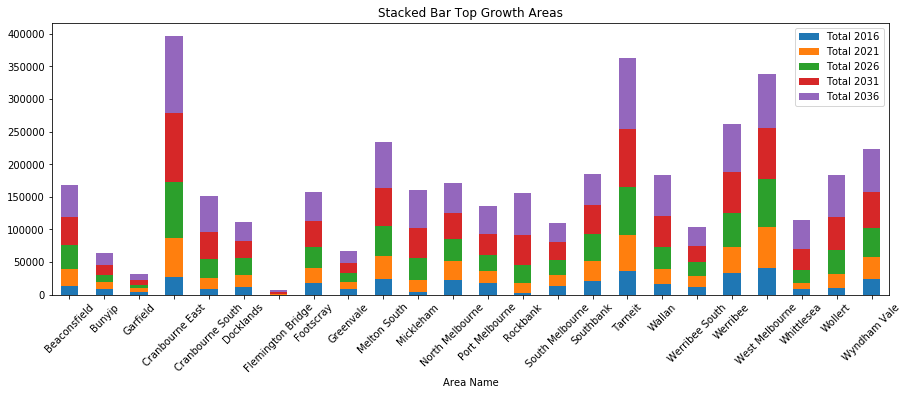

In [154]:
top_stacked = over_100perc_growth[["Area Name", "Total 2016","Total 2021","Total 2026","Total 2031","Total 2036"]]
 
# plot data in stack manner of bar type
top_stacked.plot(x='Area Name', kind='bar', stacked=True,figsize=(15,5), rot=45,
        title='Stacked Bar Top Growth Areas')
plt.show()

In [172]:
ptv_trip = pd.read_csv("Resources/P1_trip_frequency.csv")

top_growth_ptv_merge = pd.merge(over_100perc_growth, ptv_trip, how = "left", left_on="Area Name", right_on="Suburb")

top_growth_ptv_merge=top_growth_ptv_merge[["Area Name","Municipality","Total 2016", "Total 2036","Total Growth", "Total Growth %","Grand Total", "trips_per_stop"]]
top_growth_ptv_merge["Stops"] = top_growth_ptv_merge["Grand Total"]/top_growth_ptv_merge["trips_per_stop"]
top_growth_ptv_merge["Stops_pp_2016"]=top_growth_ptv_merge["Stops"]/top_growth_ptv_merge["Total 2016"]
top_growth_ptv_merge["Stops_pp_2036"]= (top_growth_ptv_merge["Stops"]/top_growth_ptv_merge["Total 2036"])*10000
top_growth_ptv_merge["Total stops and frequency"]= (top_growth_ptv_merge["Grand Total"]/top_growth_ptv_merge["Total 2036"])*10000
top_growth_ptv_merge["Increasee stops pp %"] = ((top_growth_ptv_merge["Stops_pp_2036"]-top_growth_ptv_merge["Stops_pp_2016"])/top_growth_ptv_merge["Total 2016"])*100
top_growth_ptv_merge
# Removing rows with nan values
remove_ptv_merge =["Bunyip", "Garfield","Wallan","Flemington Bridge","Port Melbourne Industrial"]
top_growth_ptv_merge = top_growth_ptv_merge[~top_growth_ptv_merge["Area Name"].isin(remove_ptv_merge)]


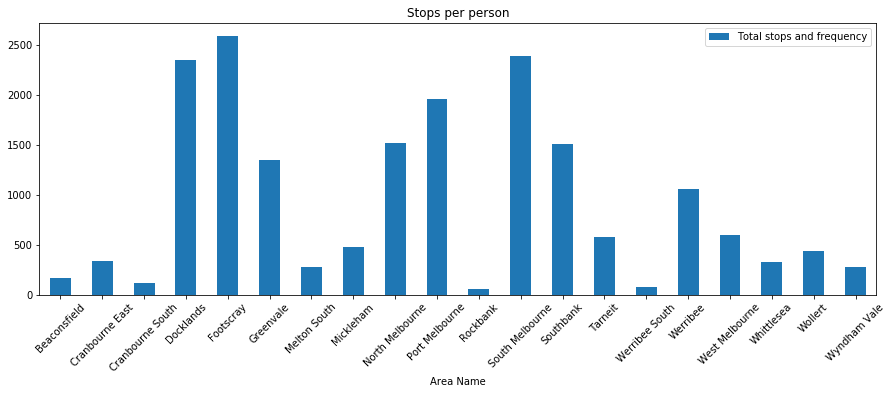

In [174]:
top_growth_ptv_merge.plot(x='Area Name', y='Total stops and frequency',kind='bar', figsize=(15,5), rot=45,
        title='Stops per person')